وارد کردن کتابخانه‌های مورد نیاز برای مدیریت فایل، پردازش داده‌های عددی و جدولی، و رسم نمودارها .

In [1]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

تعریف مسیر سه فایل داده (train، validation، test) 
با استفاده از کلاس Path
بررسی اینکه هر سه فایل وجود داشته باشند؛ اگر هرکدام موجود نباشد، برنامه با پیام خطای مربوطه متوقف می‌شود

In [2]:
# ---------- Paths ----------
train_path = Path("./data/Dataset_1_train.csv")
valid_path = Path("./data/Dataset_1_valid.csv")
test_path  = Path("./data/Dataset_1_test.csv")
assert train_path.exists(), "Train file not found."
assert valid_path.exists(), "Valid file not found."
assert test_path.exists(), "Test file not found."

ایجاد دو آرایه یک ‌بعدی x و y از داده‌های فایل CSV 
 فایل را میخواند، فقط دو ستون اول را استخراج و نام آن ها راx  و y می‌گذارد. 
تبدیل داده‌ها به آرایه عددی numpy  
استفاده از این تابع برای خواندن داده‌ های train، validation، test

In [3]:
# ---------- IO helpers ----------
def read_xy(path: Path):
    """Read a 2-column CSV and return (x, y) as 1-D numpy arrays."""
    # Try with header; if more than 2 columns or header wrong, fallback
    try:
        df = pd.read_csv(path)
        if df.shape[1] < 2:
            # Retry no header
            df = pd.read_csv(path, header=None)
            df = df.iloc[:, :2]
            df.columns = ["x", "y"]
        else:
            # Keep first two columns only
            df = df.iloc[:, :2]
            # Rename to x, y if needed
            df.columns = ["x", "y"]
    except Exception:
        df = pd.read_csv(path, header=None)
        df = df.iloc[:, :2]
        df.columns = ["x", "y"]
    x = df["x"].to_numpy().astype(float).ravel()
    y = df["y"].to_numpy().astype(float).ravel()
    return x, y, df

x_train, y_train, df_train = read_xy(train_path)
x_valid, y_valid, df_valid = read_xy(valid_path)
x_test,  y_test,  df_test  = read_xy(test_path)

تعریف چهار تابع برای مدل‌سازی رگرسیون چند جمله ‌ای

In [4]:

# ---------- Math helpers ----------
def design_matrix(x: np.ndarray, degree: int) -> np.ndarray:
    """Create Vandermonde-like design matrix [1, x, x^2, ..., x^degree]."""
    x = np.asarray(x).ravel()
    cols = [np.ones_like(x)]
    for d in range(1, degree + 1):
        cols.append(x ** d)
    return np.column_stack(cols)

def closed_form_w(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Compute (X^T X)^{-1} X^T y (with pseudo-inverse fallback)."""
    XtX = X.T @ X
    Xty = X.T @ y
    try:
        w = np.linalg.solve(XtX, Xty)
    except np.linalg.LinAlgError:
        w = np.linalg.pinv(XtX) @ Xty
    return w

def predict(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    return X @ w

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

این بخش، مدل رگرسیون خطی (درجه ۱) را روی داده‌های آموزش می‌سازد و نتایج آن را روی سه بخش داده ارزیابی می‌کند سپس عملکرد مدل را روی داده‌های (Train, Valid, Test) ارزیابی و ترسیم می‌کند

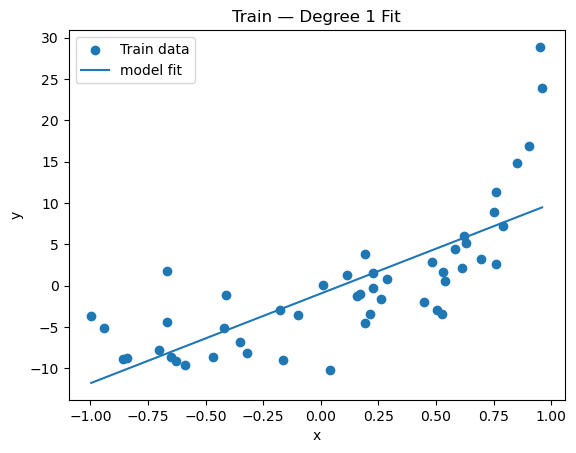

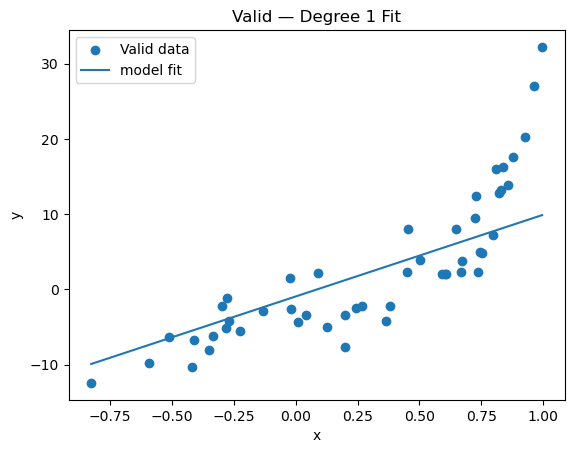

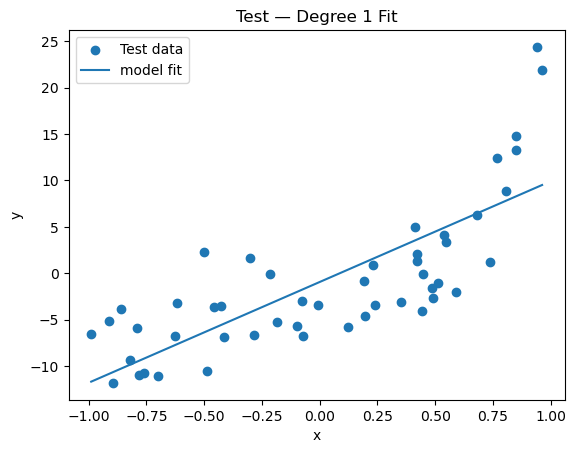

In [7]:
# ---------- Part 1: Linear Regression (degree = 1) ----------
deg_linear = 1
X_train_lin = design_matrix(x_train, deg_linear)
w_lin = closed_form_w(X_train_lin, y_train)

# Evaluate on all splits
def eval_split(name, x, y, w, degree, save_prefix):
    X = design_matrix(x, degree)
    yhat = predict(X, w)
    score = rmse(y, yhat)

    # Plot scatter + fitted curve/line
    plt.figure()
    plt.scatter(x, y, label=f"{name} data")
    # Create sorted grid for a clean line
    xs = np.linspace(float(np.min(x)), float(np.max(x)), 400)
    Xs = design_matrix(xs, degree)
    ys = predict(Xs, w)
    plt.plot(xs, ys, label="model fit")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{name} — Degree {degree} Fit")
    plt.legend()
    out_png = f"./data/{save_prefix}_{name.lower()}.png"
    plt.savefig(out_png, bbox_inches="tight", dpi=150)
    plt.show()

    return score, out_png

rmse_lin_train, png_lin_train = eval_split("Train", x_train, y_train, w_lin, deg_linear, "linear_fit")
rmse_lin_valid, png_lin_valid = eval_split("Valid", x_valid, y_valid, w_lin, deg_linear, "linear_fit")
rmse_lin_test,  png_lin_test  = eval_split("Test",  x_test,  y_test,  w_lin, deg_linear, "linear_fit")

جستجوی برای یافتن بهترین درجه چندجمله‌ای مدل رگرسیون که کمترین RMSE را روی داده valid داشته باشد

In [8]:
# ---------- Part 2: Polynomial Regression (degree selection by Valid) ----------
max_degree = 15  # You can change this search range if needed
results_poly = []

for d in range(1, max_degree + 1):
    Xtr = design_matrix(x_train, d)
    w = closed_form_w(Xtr, y_train)
    # Evaluate on valid
    Xv = design_matrix(x_valid, d)
    yv_hat = predict(Xv, w)
    score_v = rmse(y_valid, yv_hat)
    results_poly.append({"degree": d, "rmse_valid": score_v})

df_poly = pd.DataFrame(results_poly)
best_row = df_poly.loc[df_poly["rmse_valid"].idxmin()]
best_degree = int(best_row["degree"])

# Fit best polynomial on train
X_train_best = design_matrix(x_train, best_degree)
w_poly = closed_form_w(X_train_best, y_train)

ارزیابی عملکرد مدل روی داده‌های (Train)، (Valid) و (Test) 

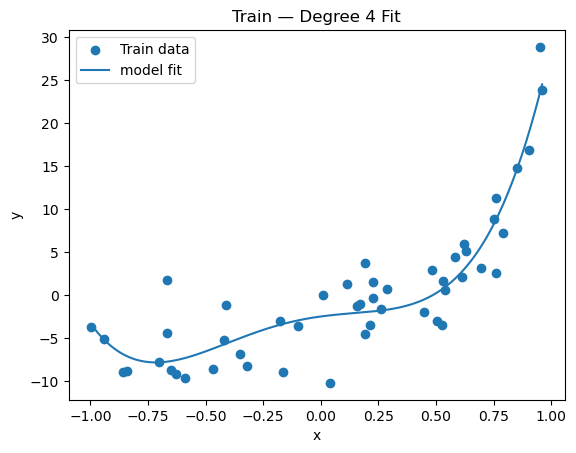

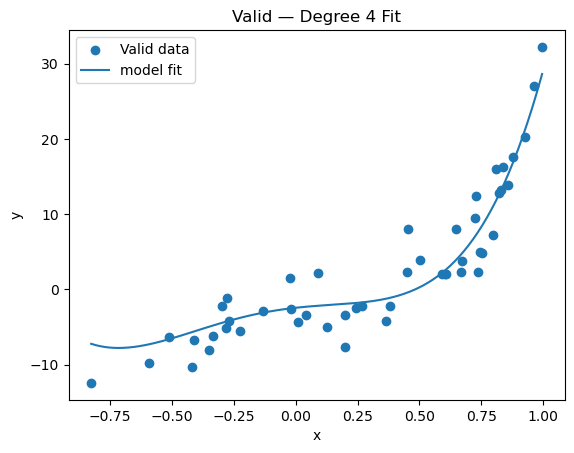

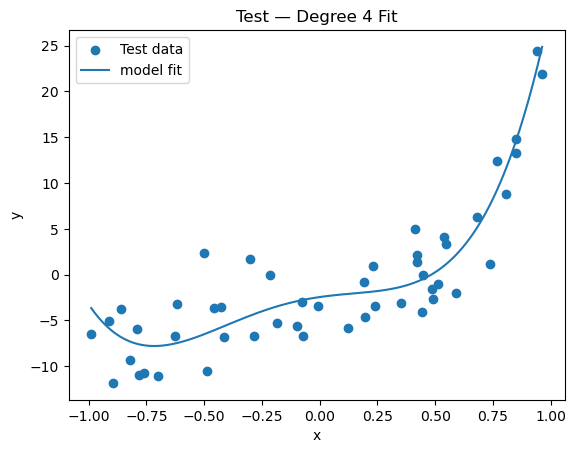

In [9]:

# Evaluate on all splits with plots
rmse_poly_train, png_poly_train = eval_split("Train", x_train, y_train, w_poly, best_degree, f"poly_d{best_degree}")
rmse_poly_valid, png_poly_valid = eval_split("Valid", x_valid, y_valid, w_poly, best_degree, f"poly_d{best_degree}")
rmse_poly_test,  png_poly_test  = eval_split("Test",  x_test,  y_test,  w_poly, best_degree, f"poly_d{best_degree}")


چاپ خروجی نهایی مربوط به انتخاب بهترین درجه چندجمله‌ای

In [15]:
print("\n=== Degree selection (by Valid RMSE) ===")
print(df_poly.to_string(index=False))
print(f"\nBest degree by Valid RMSE: d = {best_degree}")


=== Degree selection (by Valid RMSE) ===
 degree  rmse_valid
      1    5.929249
      2    4.369640
      3    3.638407
      4    2.984683
      5    3.043433
      6    3.064164
      7    3.116550
      8    3.094314
      9    3.210650
     10    3.210877
     11    3.225588
     12    4.206287
     13    3.612108
     14    5.087994
     15    3.964172

Best degree by Valid RMSE: d = 4


خلاصه ای از عملکرد دو مدل (رگرسیون خطی و چندجمله‌ای با بهترین درجه) روی سه بخش دادهTrain، Valid، Test

In [14]:
# ---------- Summaries ----------
summary_rows = [
    {"model": "Linear (d=1)", "split": "Train", "RMSE": rmse_lin_train},
    {"model": "Linear (d=1)", "split": "Valid", "RMSE": rmse_lin_valid},
    {"model": "Linear (d=1)", "split": "Test",  "RMSE": rmse_lin_test},
    {"model": f"Polynomial (d={best_degree})", "split": "Train", "RMSE": rmse_poly_train},
    {"model": f"Polynomial (d={best_degree})", "split": "Valid", "RMSE": rmse_poly_valid},
    {"model": f"Polynomial (d={best_degree})", "split": "Test",  "RMSE": rmse_poly_test},
]
df_summary = pd.DataFrame(summary_rows)
summary_rows

[{'model': 'Linear (d=1)', 'split': 'Train', 'RMSE': 5.43152976578808},
 {'model': 'Linear (d=1)', 'split': 'Valid', 'RMSE': 5.9292491068151785},
 {'model': 'Linear (d=1)', 'split': 'Test', 'RMSE': 5.0852898384254175},
 {'model': 'Polynomial (d=4)', 'split': 'Train', 'RMSE': 3.1587182717734206},
 {'model': 'Polynomial (d=4)', 'split': 'Valid', 'RMSE': 2.9846830059043343},
 {'model': 'Polynomial (d=4)', 'split': 'Test', 'RMSE': 3.2372733543572867}]